In [1]:
import tensorflow as tf
import os
from keras.backend.tensorflow_backend import set_session
import re
import pickle
import json
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import unicodedata
import numpy

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
sys.path.append('../BERT-keras/')

/home/caitingting/anaconda3/envs/BERT-Keras/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/caitingting/anaconda3/envs/BERT-Keras/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/caitingting/anaconda3/envs/BERT-Keras/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)]

# 数据预处理

In [2]:
# data 路径定义
data_origins = './CMeIE/'

In [3]:
Disease_Disease_Label_Mapping = {
    '并发症':'C',
    '病理分型':'PA',
    '相关（导致）':'RO',
    '鉴别诊断':'DD',
    '相关（转化）':'RT',
    '相关（症状）':'RS'
}

cate = ['O']
for item in Disease_Disease_Label_Mapping.values():
    cate.append('B-'+ item + '-1')
    cate.append('I-'+ item + '-1')
    cate.append('B-'+ item + '-2')
    cate.append('I-'+ item + '-2')
id_list = [i for i in range(1,len(cate)+1)]
cate_dict = {item[0]:item[1] for item in zip(cate,id_list)}
cate_dict['None'] = 0

cate_dict

{'B-C-1': 2,
 'B-C-2': 4,
 'B-DD-1': 14,
 'B-DD-2': 16,
 'B-PA-1': 6,
 'B-PA-2': 8,
 'B-RO-1': 10,
 'B-RO-2': 12,
 'B-RS-1': 22,
 'B-RS-2': 24,
 'B-RT-1': 18,
 'B-RT-2': 20,
 'I-C-1': 3,
 'I-C-2': 5,
 'I-DD-1': 15,
 'I-DD-2': 17,
 'I-PA-1': 7,
 'I-PA-2': 9,
 'I-RO-1': 11,
 'I-RO-2': 13,
 'I-RS-1': 23,
 'I-RS-2': 25,
 'I-RT-1': 19,
 'I-RT-2': 21,
 'None': 0,
 'O': 1}

In [4]:
with open(data_origins + 'CMeIE_train', 'rb') as f_train:
    train_text_label = pickle.load(f_train)
with open(data_origins + 'CMeIE_dev', 'rb') as f_dev:
    dev_text_label = pickle.load(f_dev)

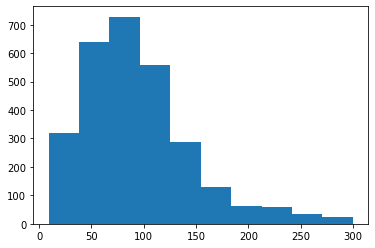

In [5]:
length = [len(item) for item in train_text_label['label']]
%matplotlib inline
plt.hist(length)
plt.show()

In [6]:
from google_bert.tokenization import _is_control, _is_whitespace, load_vocab,convert_by_vocab

def _is_chinese_char(char):
    """Checks whether CP is the codepoint of a CJK character."""
    # This defines a "chinese character" as anything in the CJK Unicode block:
    #   https://en.wikipedia.org/wiki/CJK_Unified_Ideographs_(Unicode_block)
    #
    # Note that the CJK Unicode block is NOT all Japanese and Korean characters,
    # despite its name. The modern Korean Hangul alphabet is a different block,
    # as is Japanese Hiragana and Katakana. Those alphabets are used to write
    # space-separated words, so they are not treated specially and handled
    # like the all of the other languages.
    cp = ord(char)
    if ((cp >= 0x4E00 and cp <= 0x9FFF) or  #
            (cp >= 0x3400 and cp <= 0x4DBF) or  #
            (cp >= 0x20000 and cp <= 0x2A6DF) or  #
            (cp >= 0x2A700 and cp <= 0x2B73F) or  #
            (cp >= 0x2B740 and cp <= 0x2B81F) or  #
            (cp >= 0x2B820 and cp <= 0x2CEAF) or
            (cp >= 0xF900 and cp <= 0xFAFF) or  #
            (cp >= 0x2F800 and cp <= 0x2FA1F)):  #
        return True

    return False

def _run_strip_accents(text):
    """Strips accents from a piece of text."""
    text = unicodedata.normalize("NFD", text)
    output = []
    for char in text:
        cat = unicodedata.category(char)
        if cat == "Mn":
            continue
        output.append(char)
    return "".join(output)

def _word_piece_tokenize(token, vocab, unk_token="[UNK]", max_input_chars_per_word=200):
    chars = list(token)
    if len(chars) > max_input_chars_per_word:
        return [unk_token], [0 for i in range(len(chars))]

    is_bad = False
    start = 0
    sub_tokens = []
    sub_tokens_offset = [0 for i in range(len(chars))]
    
    while start < len(chars):
        end = len(chars)
        cur_substr = None
        while start < end:
            substr = "".join(chars[start:end])
            if start > 0:
                substr = "##" + substr
            if substr in vocab:
                cur_substr = substr
                break
            end -= 1
        if cur_substr is None:
            is_bad = True
            break
        sub_tokens.append(cur_substr)
        for i in range(start,end):
            sub_tokens_offset[i] = len(sub_tokens) - 1
        start = end

    if is_bad:
        return [unk_token], [0 for i in range(len(chars))]
    else:
        return sub_tokens, sub_tokens_offset

class BERTTextEncoder(object):
    def __init__(self, vocab_file: str, do_lower_case: bool = True) -> None:
        self.do_lower_case = do_lower_case
        
        # vocab词表信息
        self.vocab = load_vocab(vocab_file)
        self.inv_vocab = {v: k for k, v in self.vocab.items()}
        
        # 加载对应
        self.bert_pad_id = self.vocab['[PAD]']
        # 99 used
        self.bert_unk_id = self.vocab['[UNK]']
        self.bert_cls_id = self.vocab['[CLS]']
        self.bert_sep_id = self.vocab['[SEP]']
        self.bert_msk_id = self.vocab['[MASK]']
        self.vocab_size = len(self.vocab) - 99 - 5
        
        
    def standardize_ids(self, ids):
        for i in range(len(ids)):
            if ids[i] == self.bert_pad_id:  # PAD
                ids[i] = 1 + self.vocab_size
            elif ids[i] == self.bert_unk_id:  # UNK
                ids[i] = 0
            elif ids[i] == self.bert_cls_id:  # CLS
                ids[i] = 3 + self.vocab_size
            elif ids[i] == self.bert_sep_id:  # SEP
                ids[i] = 5 + self.vocab_size
            elif ids[i] == self.bert_msk_id:  # MASK
                ids[i] = 2 + self.vocab_size
            elif ids[i] > self.bert_msk_id:  # VOCAB
                ids[i] -= self.bert_msk_id
        return ids

    # 返回 tokens, real_token_offset
    def tokenize(self, strA):
        orig_tokens = []
        char_orig_token_offset = []
        
        is_token_start = True
        is_token_end = False
        # 初步分词
        for char in strA:
            cp = ord(char)
            
            if cp == 0 or cp == 0xfffd or _is_control(char):
                char = ''
            elif _is_whitespace(char):
                is_token_end = True
                char = ''
            elif _is_chinese_char(char):
                is_token_start = True
                is_token_end = True
                
                
            if is_token_start:
                if len(orig_tokens) == 0 or len(orig_tokens[-1]) != 0: 
                    orig_tokens.append('')
                is_token_start = False
            
            if char == '':
                char_orig_token_offset.append(None)
            else:
                char_orig_token_offset.append((len(orig_tokens) - 1, len(orig_tokens[-1])))
                orig_tokens[-1] += char
        
            if is_token_end:
                is_token_start = True
                is_token_end = False
        
        if orig_tokens[-1] == '':
            orig_tokens.pop()
        
        
        # 详细分词
        
        split_tokens = []
        split_tokens_map = {}
        
        for idx, token in enumerate(orig_tokens):
            if self.do_lower_case:
                token = token.lower()
                token = _run_strip_accents(token)
            
            sub_tokens, sub_tokens_offset = _word_piece_tokenize(token, self.vocab)
            
            for o_idx, offset in enumerate(sub_tokens_offset):
                split_tokens_map[(idx, o_idx)] =  len(split_tokens) + offset
            
            split_tokens.extend(sub_tokens)
            
        
        real_token_offset = []
        
        for offset in char_orig_token_offset:
            if offset is None:
                real_token_offset.append(None)
            elif offset in split_tokens_map:
                real_token_offset.append(split_tokens_map[offset])
            else:
                real_token_offset.append(None)
                
        
        return split_tokens, real_token_offset
    
    def convert_tokens_to_ids(self, tokens):
        return convert_by_vocab(self.vocab, tokens)

In [7]:
# bert 路径定义
bert_parameter_location = '../BERT-keras/google_bert/downloads/chinese_L-12_H-768_A-12/'

# 文本最长大小
max_len = 128

# bert解码器引入
bert_encoder = BERTTextEncoder(os.path.join(bert_parameter_location, 'vocab.txt'))

In [8]:
from data.dataset import generate_pos_ids

def ner_prepare(input_texts, output_labs, bert_encoder, cate_dict, max_len):
    input_ids = []
    input_masks = []
    input_type_ids = np.zeros((len(input_texts), max_len), dtype=np.int32)
    output_ids = []
    
    for input_text,output_lab in tqdm(zip(input_texts,output_labs)):
        try:
            tokens, char_to_word_offset = bert_encoder.tokenize(input_text)
        
            if len(tokens) > max_len - 2: #删除多余字符
                tokens = tokens[0:(max_len - 2)]       

            order = {"O":1,'I':2,"B":3} #维护一个优先级，对tokens倒序遍历，
            output = ["O" for i in range(len(tokens))]
#             output = ['O'] * len(tokens)
        
            for idx in range(len(output_lab)):
                real_idx = char_to_word_offset[idx]
                if real_idx != None: #若某个char是空格等，对应到token中会删去，char_to_word_offset对应位置存储为None。
                    if real_idx >= max_len - 2: #超出最大长度部分不考虑
                        break
                    if order[output_lab[idx][0]] > order[output[real_idx][0]]:#防止存在tokens和人标的边界不一致的情况，导致标签错误。eg，tokens中“1000元”，人标“000元”
                        output[real_idx] = output_lab[idx]
                        
        except Exception as e:
            print(input_text)
            raise e


        tokens = ['[CLS]'] + tokens + ['[SEP]'] # 拼接开始字符，结束字符
        input_id = bert_encoder.standardize_ids(bert_encoder.convert_tokens_to_ids(tokens))
        
        output = ['O'] + output + ['O']
        output_id =  [cate_dict[item] if item in cate_dict else cate_dict['O'] for item in output]

        input_mask = [1] * (len(tokens))

        input_id += [0] * (max_len - len(tokens))
        output_id += [0] * (max_len - len(tokens))
        input_mask += [0] * (max_len - len(tokens))

        input_ids.append(input_id)
        output_ids.append(output_id)
        input_masks.append(input_mask)
        
    input_ids=np.array(input_ids, dtype=np.int32)
    output_ids=np.array(output_ids, dtype=np.int32)
    input_masks=np.array(input_masks, dtype=np.int32)
        
    pos = generate_pos_ids(len(input_texts), max_len)
#     attention_mask = create_attention_mask(input_masks, False, None, None, True) 
    
    return [input_ids, input_type_ids, pos, input_masks], output_ids

if you want sentencepiece encoder, please install sentencepiece
if you want to use OpenAI's encoder and pretrained model, please install spacy, and ftfy


In [9]:
x_train, y_train = ner_prepare(train_text_label['text'], train_text_label['label'], bert_encoder, cate_dict, max_len)
x_dev, y_dev = ner_prepare(dev_text_label['text'], dev_text_label['label'], bert_encoder, cate_dict, max_len)

2842it [00:01, 2030.53it/s]
693it [00:00, 2169.44it/s]


In [10]:
y_train = y_train[:,:,np.newaxis]
y_dev = y_dev[:,:,np.newaxis]

# 评测函数

In [11]:
index_tag = {value: key for key, value in cate_dict.items()}

values = bert_encoder.standardize_ids(list(bert_encoder.vocab.values()))
keys = list(bert_encoder.vocab.keys())
index_char = {value: key for key, value in zip(keys, values)}
id2label_dict = {value:key for key,value in cate_dict.items()}

In [12]:
#预测结果
from seqeval.metrics import classification_report,f1_score

def calculate_PRF(y_val,y_pred,id2label_dict):
    true_val = np.squeeze(y_val)
    true_val = [[id2label_dict[w] if w != 0 else 'O' for w in s] for s in true_val] 

#     pred_val = model.predict(x_val)
    pred_val = np.argmax(y_pred,axis = -1)
    pred_val = [[id2label_dict[w] if w != 0 else 'O' for w in s] for s in pred_val] 
    
    report = classification_report(true_val , pred_val)
    f1 = f1_score(true_val , pred_val)
    write2file(report)
    print(report)
    return f1

In [13]:
def get_ens_from_label(label):
#         print(label)
    label = label + ['O']#为了解决最后一个字符是B或者I的情况
    en_start = -1
    en_type = ""
    ens = []
    for idx,lab in enumerate(label):
#             print(label)
        if lab[0] == 'B' and en_start == -1:
            en_start = idx
            en_type = lab[2:]
        elif lab[0] == 'B' and en_start != -1: #解决两个连续实体的情况，中间没有‘O’
            ens.append((en_type,en_start,idx))
            en_start = idx
            en_type = lab[2:]
        elif lab[0] == 'I' and en_start == -1:
#             print ("标签序列错误,I不可能是起始标签。")
            continue
        elif lab[0] == 'I' and en_start != -1 and lab[2:]!=en_type:
            ens.append((en_type,en_start,idx))
            en_start = -1
        elif lab[0] == 'O' and en_start == -1:
            pass
        elif lab[0] == 'O' and en_start != -1 :
            ens.append((en_type,en_start,idx))
            en_start = -1
    return ens

def char_to_word(char_to_word_offset): 
    word_to_char_offset = {}
    char_range = []
    temp_id = char_to_word_offset[0]
    for char_id, word_id in enumerate(char_to_word_offset+[-1]):
        if word_id != temp_id:
            word_to_char_offset[temp_id] = char_range
            char_range = []
            char_range.append(char_id)
        else:
            char_range.append(char_id)
        temp_id = word_id
    return word_to_char_offset

In [14]:
def get_ens_list(input_val,pred_lab):
    char_ens_list = [] #存储实体列表，shape = (sample_num,ens_num,4),格式为[[(en_type,char_start,char_end,en_text)]]
    for item in tqdm(zip(input_val,pred_lab)):
#         print(item)
        char_ens = []

        text = item[0]
        pred_lab = item[1] #为set类型

        tokens, char_to_word_offset = bert_encoder.tokenize(text)
        word_to_char_offset = char_to_word(char_to_word_offset)

        pred_lab = pred_lab[1:-1]  #去掉CLS和SEP位置对应的'O'标签

        ens = get_ens_from_label(pred_lab)

        #对实体列表进行遍历，找到预测实体对应的原文
        for en_type,en_start,en_end in ens:
    #         if en_start >= len(tokens) or en_end-1> len(tokens):
    #             print("预测结果将None也预测成了BIO标签")
    #             continue

            try:
                char_start = word_to_char_offset[en_start][0]
                char_end = word_to_char_offset[en_end -1][-1] +1 #位置均为左闭右开
            except Exception as e2:
                print(len(pred_lab))
    #             print(text)
                print(len(tokens))
    #             print(ens)
    #             print(len(word_to_char_offset))
    #             print(word_to_char_offset)
    #             print(en_end-1)
                continue
                raise 

            en_text = text[char_start:char_end]
            char_ens.append((en_type,char_start,char_end,en_text))
        char_ens_list.append(char_ens)
    return char_ens_list

In [15]:
import itertools

def get_relations(pred_ens_list):
    
    pred_relation_list = []
    for item in pred_ens_list:
        tmp_relation_list = []
        label = list(set(list(map(lambda x:x[0].split('-')[0],item))))
        label_content = list(map(lambda x:(x[0],x[-1]),item))
        all_label_content_set = []
        for tmp in label_content:
            if tmp not in all_label_content_set:
                all_label_content_set.append(tmp)

        for relation in label:
            label_content_set = list(filter(lambda x:x[0].split('-')[0] == relation,all_label_content_set))
            subject_count = len(list(filter(lambda x:x[0].split('-')[-1] == '1',label_content_set)))
            object_count = len(list(filter(lambda x:x[0].split('-')[-1] == '2',label_content_set)))

            if subject_count !=0 and object_count != 0:
                final_count = max(subject_count,object_count)
            else:
                final_count = 0

            tmp_list = []


            while subject_count != 1 and object_count != 1 and subject_count !=0 and object_count != 0:
                flag = False
                subject_object_flag = False
                for index,tmp in enumerate(label_content_set):
                    if tmp[0].split('-')[-1] == '1':
                        flag = True
                        subject_index = index
                    if tmp[0].split('-')[-1] == '2' and flag:
                        tmp_list.append([label_content_set[subject_index],tmp])
                        label_content_set = label_content_set[:subject_index]+label_content_set[subject_index+1:index]+label_content_set[index+1:]
                        flag = False
                        subject_count = len(list(filter(lambda x:x[0].split('-')[-1] == '1',label_content_set)))
                        object_count = len(list(filter(lambda x:x[0].split('-')[-1] == '2',label_content_set)))
                        subject_object_flag = True
                        break

                if not subject_object_flag:
                    for index,tmp in enumerate(label_content_set):
                        if tmp[0].split('-')[-1] == '2':
                            flag = True
                            object_index = index
                        if tmp[0].split('-')[-1] == '1' and flag:
                            tmp_list.append([tmp,label_content_set[object_index]])
                            label_content_set = label_content_set[:object_index]+label_content_set[object_index+1:index]+label_content_set[index+1:]
                            flag = False
                            subject_count = len(list(filter(lambda x:x[0].split('-')[-1] == '1',label_content_set)))
                            object_count = len(list(filter(lambda x:x[0].split('-')[-1] == '2',label_content_set)))
                            break
            tmp_list.append(label_content_set)

            for lists in tmp_list:
                for tmp in itertools.combinations(lists, 2):
                    if tmp[0][0].split('-')[-1] != tmp[-1][0].split('-')[-1]:
                        tmp_relation_list.append((tmp[0][-1],tmp[-1][-1],relation))

        pred_relation_list.append(tmp_relation_list)
        
    return pred_relation_list


In [16]:
def Evaluate(relation_list,pred_relation_list,true_relation_list):
    dic = {}
    all_score = {}
    all_precision = float(0)
    all_recall = float(0)
    all_f = float(0)
    for relation in relation_list:
        pred_count = 0
        true_count = 0
        true_pred_count = 0
        for i in range(len(pred_relation_list)):
            
            pred_relation = list(filter(lambda x:x[-1] == relation if x else [], pred_relation_list[i]))
            true_relation = list(filter(lambda x:x[-1] == relation if x else [], true_relation_list[i]))
            
            pred_count+=len(pred_relation)
            true_count+=len(true_relation)
            true_pred = [item for item in pred_relation if item in true_relation]
            true_pred_count+=len(true_pred)
          
                
        if pred_count==0:
            p = 0
        else:
            p = true_pred_count/pred_count*100
        if true_count==0:
            r = 0
        else:
            r = true_pred_count/true_count*100
        if p == 0 or r == 0:
            f = 0
        else:
            f = 2*p*r/(p+r)
        support = true_count
        dic[relation] = {
            'precision':'%.2f' %(p),
            'recall':'%.2f' %(r),
            'f1-score':'%.2f' %(f),
            'support':support,
        }
    sum_support = sum(list(map(lambda x:x['support'],dic.values())))
    p_s = list(map(lambda x:(x['precision'],x['support']),dic.values()))
    r_s = list(map(lambda x:(x['recall'],x['support']),dic.values()))
    f_s = list(map(lambda x:(x['f1-score'],x['support']),dic.values()))
    for j in range(len(p_s)):
        all_precision+=float(float(p_s[j][0])*p_s[j][1]/sum_support)
    all_precision = '%.2f' %(all_precision)
    for k in range(len(r_s)):
        all_recall+=float(float(r_s[k][0])*r_s[k][1]/sum_support)
    all_recall = '%.2f' %(all_recall)
    for l in range(len(f_s)):
        all_f+=float(float(f_s[l][0])*f_s[l][1]/sum_support)
    all_f = '%.2f' %(all_f)

    classification_report = '          precision    recall  f1-score   support\n\n'
    for relation in dic:
        if len(relation)>=4:
            classification_report+=str(relation+' '*(10-len(relation))+str(dic[relation]['precision'])+' '*(11-len(str(dic[relation]['precision'])))+str(dic[relation]['recall'])+' '*(11-len(str(dic[entity]['recall'])))+str(dic[relation]['f1-score'])+' '*(11-len(str(dic[relation]['f1-score'])))+str(dic[relation]['support'])+'\n')
        else:
            classification_report+=str('  '+relation+' '*(10-len(relation))+str(dic[relation]['precision'])+' '*(11-len(str(dic[relation]['precision'])))+str(dic[relation]['recall'])+' '*(11-len(str(dic[relation]['recall'])))+str(dic[relation]['f1-score'])+' '*(11-len(str(dic[relation]['f1-score'])))+str(dic[relation]['support'])+'\n')
    classification_report+='\navg score'+  ' '*(14-len('avg score'))+str(all_precision)+ ' '*(11-len(str(all_precision)))+str(all_recall)+ ' '*(11-len(str(all_recall)))+str(all_f)+' '*(11-len(str(all_f)))+str(sum_support)    
    
    dic['avg_score'] = {
        'precision':all_precision,
        'recall':all_recall,
        'f1-score':all_f,
        'support':sum_support
    }
    
    return dic,classification_report

# 主动学习流程

# 定义base model为BERT-CRF

In [17]:
from transformer.load import load_google_bert

bert_model = load_google_bert(bert_parameter_location,max_len = max_len)

In [18]:
from keras import backend as K
from keras.layers import Layer

class BertMask(Layer):
    def __init__(self, **kwargs):
        self.supports_masking = True
        super(BertMask, self).__init__(**kwargs)

    def compute_mask(self, inputs, input_mask=None):
#         print(inputs, input_mask)
#         mask = K.squeeze(inputs[1], axis=1)
#         return K.equal(mask[:,0], 1)
        return K.equal(inputs[1], 1)

    def call(self, inputs, mask=None):
        return inputs[0]

    def compute_output_shape(self, input_shape):
        return input_shape[0]

In [19]:
from keras_contrib.layers import CRF
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy


def bert_crf():
    bert_mask = BertMask()([bert_model.output, bert_model.input[3]])

    dense1 = Dense(768,activation = 'tanh')(bert_mask)

    # bilstm = Bidirectional(LSTM(int(bert_model.output.shape[-1])//2, return_sequences=True))(bert_mask)

    crf =  CRF(len(cate_dict), sparse_target=True, name = 'crf',learn_mode = 'marginal')(dense1)

    #sparse_target=True表示输出可以不用转成one-hot，直接一个向量代表一个句子的bieo序列即可

    model = Model(inputs=bert_model.input, outputs = crf)

    adam = Adam(lr=5e-06, decay=0.0)
    model.compile(adam, loss = crf_loss, metrics=[crf_viterbi_accuracy])

    model.summary()
    return model

# 设置训练方法

In [20]:
def ner_result_id2type(ner_result, netype_dict):
    types_lists = []
    rows, cols = ner_result.shape
    for i in range(rows):
        types_list = []
        for j in range(cols):
            type_ = netype_dict[ner_result[i,j]]
#             if type_ == 'null':
#                 types_list.append('S')
#             else:
            types_list.append(type_)
        types_lists.append(types_list)
    return types_lists

In [21]:
from seqeval.metrics import *

def predict(model,x_test,y_test):
    result = {}
    y_pred = model.predict(x_test, batch_size=128)
    pred_dev = np.argmax(y_pred,axis = -1)
    pred_dev = [[id2label_dict[w] if w != 0 else 'O' for w in s] for s in pred_dev] 

    true_dev = np.squeeze(y_dev)
    true_dev = [[id2label_dict[w] if w != 0 else 'O' for w in s] for s in true_dev] 

    pred_ens_list = get_ens_list(dev_text_label['text'],pred_dev) 
    true_ens_list = get_ens_list(dev_text_label['text'],true_dev) 

    pred_relation_list = get_relations(pred_ens_list)
    true_relation_list = get_relations(true_ens_list)

    dic,classification_report = Evaluate(Disease_Disease_Label_Mapping.values(),pred_relation_list,true_relation_list)
    result['F'] = dic['avg_score']['f1-score']
    result['P'] = dic['avg_score']['precision']
    result['R'] = dic['avg_score']['recall']
    result['classification_report'] = classification_report
    return result

In [22]:
import datetime,time
import os
import shutil

def model_train(projectName,model,crf_numEpoch,x_train,y_train,x_val,y_val):

    print(projectName+' Train...')

    bestF = -1
    now = time.strftime("%Y-%m-%d_%H-%M-%S")
    projectPath = './param/subsequence-without-dic-token-level-lc-7-450-40-45-0.7/{}'.format(projectName)
    if not os.path.isdir(projectPath): os.makedirs(projectPath)
    resultPath = projectPath + '/{}/'.format(now)
    os.makedirs(resultPath)

    for i in range(0,crf_numEpoch):
        epoch_id = 'Epoch '+str(i+1)+"/"+str(crf_numEpoch)
        print(epoch_id)
        hist = model.fit(x_train, y_train, epochs=1, batch_size=36)
        result = predict(model,x_val,y_val)
        currentF = result['F']
        if float(currentF) > bestF:
            bestF = float(currentF)
            pathOutputModelWeights = resultPath + str(i+1).zfill(3) + "_" + str(currentF) +".txt"   
            model.save_weights(pathOutputModelWeights)
 
    print(bestF)
    return pathOutputModelWeights

# 设置初始已标注集和未标注集

In [23]:
from sklearn import model_selection
x_pool = [0]*4
x_labeled = [0]*4
pool_text_label = {}
labeled_text_label = {}
for i in range(4):
    x_pool[i],x_labeled[i], y_pool, y_labeled = model_selection.train_test_split(x_train[i],y_train,test_size=0.2 ,random_state=1213)
pool_text_label['text'], labeled_text_label['text'] = model_selection.train_test_split(train_text_label['text'],test_size=0.2 ,random_state=1213)

In [24]:
print(x_pool[0].shape)
print(y_pool.shape)
print(x_labeled[0].shape)
print(y_labeled.shape)

(2273, 128)
(2273, 128, 1)
(569, 128)
(569, 128, 1)


# 统计初始已标注集和未标注集中有多少关系

In [25]:
true_pool = np.squeeze(y_pool)
true_pool = [[id2label_dict[w] if w != 0 else 'O' for w in s] for s in true_pool] 
true_pool_list = get_ens_list(pool_text_label['text'],true_pool) 
pool_relation_list = get_relations(true_pool_list)

true_labeled = np.squeeze(y_labeled)
true_labeled = [[id2label_dict[w] if w != 0 else 'O' for w in s] for s in true_labeled] 
true_labeled_list = get_ens_list(labeled_text_label['text'],true_labeled) 
labeled_relation_list = get_relations(true_labeled_list)

2273it [00:01, 2207.63it/s]
569it [00:00, 2252.67it/s]


In [26]:
pool_relation_count = 0
for item in pool_relation_list:
    pool_relation_count += len(item)

labeled_relation_count = 0
for item in labeled_relation_list:
    labeled_relation_count += len(item)

In [27]:
print(pool_relation_count)
print(labeled_relation_count)

3883
941


# 统计初始已标注集和训练集中的关系之间的间隔

In [28]:
true_train = np.squeeze(y_train)
true_train = [[id2label_dict[w] if w != 0 else 'O' for w in s] for s in true_train] 
true_train_list = get_ens_list(train_text_label['text'],true_train) 
train_relation_list = get_relations(true_train_list)

2842it [00:01, 2189.19it/s]


In [29]:
def count_distance(labeled_relation_list, true_labeled_list):
    distance_list = []
    for index,item in enumerate(labeled_relation_list):
        for tmp in item:
            subject_ = tmp[0]
            object_ = tmp[1]
            relation = tmp[2]
            subjects = list(filter(lambda x:x[0] == relation + '-1' and x[3] == subject_,true_labeled_list[index]))
            objects = list(filter(lambda x:x[0] == relation + '-2' and x[3] == object_,true_labeled_list[index]))
            if subjects and objects:
                distance = objects[0][2]-subjects[0][1]
            distance_list.append(distance)
    return distance_list

In [30]:
train_distance_list = count_distance(train_relation_list, true_train_list)

In [31]:
labeled_distance_list = count_distance(labeled_relation_list, true_labeled_list)

In [32]:
all_distance_list = train_distance_list + labeled_distance_list

In [33]:
print(np.mean(all_distance_list))

46.34258456201214


In [34]:
print(np.median(all_distance_list))

40.0


In [35]:
from scipy import stats
print(stats.mode(all_distance_list)[0][0])

14


# 用初始的已标注集训练base model

In [36]:
base_model = bert_crf()
# best_model_weights = model_train('base_model_initial',base_model,80,x_labeled,y_labeled,x_dev,y_dev)
# base_model.load_weights(best_model_weights)
base_model.load_weights('./param/subsequence-active-learning-without-dic/base_model_initial/2021-12-21_15-04-02/070_35.91.txt')
predict(base_model,x_dev,y_dev)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
segment_input (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
position_input (InputLayer)     (None, 128)          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
SegmentEmbedding (Embedding)    (None, 128, 768)     1536        segment_input[0][0]              
__________________________________________________________________________________________________
Position

Total params: 101,918,194
Trainable params: 101,918,194
Non-trainable params: 0
__________________________________________________________________________________________________


693it [00:00, 2387.45it/s]
693it [00:00, 2349.66it/s]


{'F': '35.91',
 'P': '43.61',
 'R': '31.52',
 'classification_report': '          precision    recall  f1-score   support\n\n  C         46.60      37.80      41.74      381\n  PA        47.93      35.06      40.50      231\n  RO        22.58      12.00      15.67      175\n  DD        55.11      45.75      50.00      212\n  RT        12.50      3.90       5.94       77\n  RS        77.78      15.91      26.42      44\n\navg score     43.61      31.52      35.91      1120'}

In [37]:
n_queries = 7
n_instances = 450
subsequence_len_range = [40,45]
alpha = 0.7
dic = {}
all_score = {}
existed = []

# 迭代过程

In [ ]:
import math

for query_idx in range(n_queries):
    print('Query {n}'.format(n=query_idx + 1))
    
    y_pool_scores = []
    subsequence_scores = []
    selected_idx = []
    input_id = []
    type_id = []
    pos_id = []
    mask_id = []
    y_pool_selected = []
    
    y_pool_pred = base_model.predict(x_pool,batch_size=128)
    
    for i in range(y_pool_pred.shape[0]):
        tmp = []
        x_pool_len = len(np.where(x_pool[0][i]!=0)[0])-2
        for j in range(y_pool_pred.shape[1]): 
            tmp.append(1-math.log(max(y_pool_pred[i][j]),math.e))
        y_pool_scores.append(tmp[1:1+x_pool_len])

    
    for l in range(subsequence_len_range[0],subsequence_len_range[1]+1):
        for i in range(len(y_pool_scores)):
            for j in range(len(y_pool_scores[i])-l+1):
                subsequence_scores.append([i,[j,j+l],sum(y_pool_scores[i][j:j+l])/(l**alpha)])
    subsequence_scores = sorted(subsequence_scores,key = lambda x:x[2],reverse = True)

    for i in range(len(subsequence_scores)):
        union = selected_idx + existed
        if [subsequence_scores[i][0],subsequence_scores[i][1]] not in union:
            selected_idx_tmp = list(filter(lambda x:x[0] == subsequence_scores[i][0],union))
            flag = True
            for item in selected_idx_tmp:
                if not (subsequence_scores[i][1][0] > item[1][1] or subsequence_scores[i][1][1] < item[1][0]):
                    flag = False
            if flag:
                selected_idx.append([subsequence_scores[i][0],subsequence_scores[i][1]])
        if len(selected_idx) == n_instances:
            break
    
    
    for item in selected_idx:
        sentence_index = item[0]
        selected_start = item[1][0]
        selected_end = item[1][1]
        x_pool_len = len(np.where(x_pool[0][sentence_index]!=0)[0])
        if x_pool[0][sentence_index][-1] == 0:
            token_tmp = [x_pool[0][sentence_index].tolist()[0]] + x_pool[0][sentence_index].tolist()[selected_start+1:selected_end+1] + [x_pool[0][sentence_index].tolist()[x_pool_len-1]]
            label_tmp = [y_pool[sentence_index].tolist()[0]] + y_pool[sentence_index].tolist()[selected_start+1:selected_end+1] + [y_pool[sentence_index].tolist()[x_pool_len-1]]
        else:
            token_tmp = [x_pool[0][sentence_index].tolist()[0]] + x_pool[0][sentence_index].tolist()[selected_start+1:selected_end+1] + [x_pool[0][sentence_index].tolist()[-1]]
            label_tmp = [y_pool[sentence_index].tolist()[0]] + y_pool[sentence_index].tolist()[selected_start+1:selected_end+1] + [y_pool[sentence_index].tolist()[-1]]
        token_list = token_tmp + [0]*(max_len-(selected_end-selected_start+2))
        label_list = label_tmp + [[0]]*(max_len-(selected_end-selected_start+2))
        input_id.append(token_list)
        type_id.append([0]*max_len)
        pos_id.append([i for i in range(max_len)])
        mask_id.append([1]*(selected_end-selected_start+2)+[0]*(max_len-(selected_end-selected_start+2)))
        y_pool_selected.append(label_list)

    x_pool_selected = [np.array(input_id),np.array(type_id),np.array(pos_id),np.array(mask_id)]
    y_pool_selected = np.array(y_pool_selected)
    
    for t in range(4):
        x_labeled[t] = np.concatenate((x_labeled[t],x_pool_selected[t]),axis = 0)    
    y_labeled = np.concatenate((y_labeled,y_pool_selected),axis = 0)    


    base_model = bert_crf()
    best_model_weights = model_train('base_model_' + str(query_idx+1),base_model,80,x_labeled,y_labeled,x_dev,y_dev)
    base_model.load_weights(best_model_weights)
    result = predict(base_model,x_dev,y_dev)



    all_score[str(query_idx+1)] = {
        'f1':result['F'],
        'recall':result['R'],
        'precision':result['P'],
        'classification_report':result['classification_report']
    }
    
    print(all_score[str(query_idx+1)])
    
    existed += selected_idx
    
#     for a in range(4):
#         x_pool[a] = np.delete(x_pool[a], selected_sentence_idx, axis=0)
#     y_pool = np.delete(y_pool, selected_sentence_idx, axis=0) 
    

Query 1
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
segment_input (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
position_input (InputLayer)     (None, 128)          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
SegmentEmbedding (Embedding)    (None, 128, 768)     1536        segment_input[0][0]              
__________________________________________________________________________________________________
Po



Epoch 1/1
1019/1019 [==============================] - 23s 23ms/step - loss: 1.3757 - crf_viterbi_accuracy: 0.6728


693it [00:00, 2331.26it/s]
693it [00:00, 2308.79it/s]


Epoch 2/80
Epoch 1/1
1019/1019 [==============================] - 13s 13ms/step - loss: 0.6782 - crf_viterbi_accuracy: 0.8243


693it [00:00, 2305.74it/s]
693it [00:00, 2306.09it/s]


Epoch 3/80
Epoch 1/1
  36/1019 [>.............................] - ETA: 12s - loss: 0.5162 - crf_viterbi_accuracy: 0.8616